# Amplifier calibration
SPA Settings:
- RBW: 3kHz
- VBW: 1000Hz
- 1001 Points
- 2G-10GHz
- Normalise the spectral density by RBW to get the power per Hz

VNA Settings:
- Power: -15dBm
- Point: 2001
- Bandwidth: 10Hz
- 2G-10GHz
- VNA measures amplitude, to convert to dB

**Procedure**
1. Measure background signal through cables using VNA
2. Measure background noise using SPA and normalise by the RBW used
3. Slot in amplifier
4. Measure gain using VNA
    \begin{equation}
      \begin{aligned}
        \text{Gain}_{dB}(f) & = \text{VNA}(f) - \text{VNA}_{bg}(f)\\
        & = 10\log(\text{GAIN} \times A_{out}/A_{in}) - 10\log{A_{out}/A_{in}}\\
        & = 10\log{\text{GAIN}}
    \end{aligned}
    \end{equation}

5. Measure noise using SPA (gain converted back to linear units)

The SPA measures the power of the noise in dBm

\begin{equation}
 \text{SPA}(f) = 10 \times\log(\text{Noise})
\end{equation}

We want to correct by the original background noise whose amplitude is boosted by the amplifier

\begin{equation}
  \begin{aligned}
    \text{SPA}_{bg-amplified}(f) & = 10 \times\log(\text{Bg Noise}\times\text{GAIN}^{2})\\
    & = 10\left[ \log(\text{Bg Noise}) + 2\log{\text{GAIN}} \right]\\
    & = \text{SPA}_{bg} + 2\text{GAIN}_{dB}
 \end{aligned}
\end{equation}

Therefore the background corrected noise will be:
\begin{equation}
  \begin{aligned}
    \text{Noise}_{dBm/Hz}(f) = 10\log{\left[ 10^{\text{SPA}/10} - 10^{\text{SPA}_{bg-amplified}/10} \right]}
\end{aligned}
\end{equation}


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

GHz = 10**9
RBW = 3000

plt.style.use('support-files/qubit.mplstyle')

def to_dBm(array):
    # Conver to dBm. Values smaller than 0 are set to the lowest value in array
    min_value = 10 * np.log(min(array[array > 0]))
    return 10 * np.nan_to_num(np.log(array), nan = min_value, neginf=min_value)

def from_dBm(array):
    return np.power(10, array / 10)

## Background
It seems that the noise registered is the internal noise of the SPA

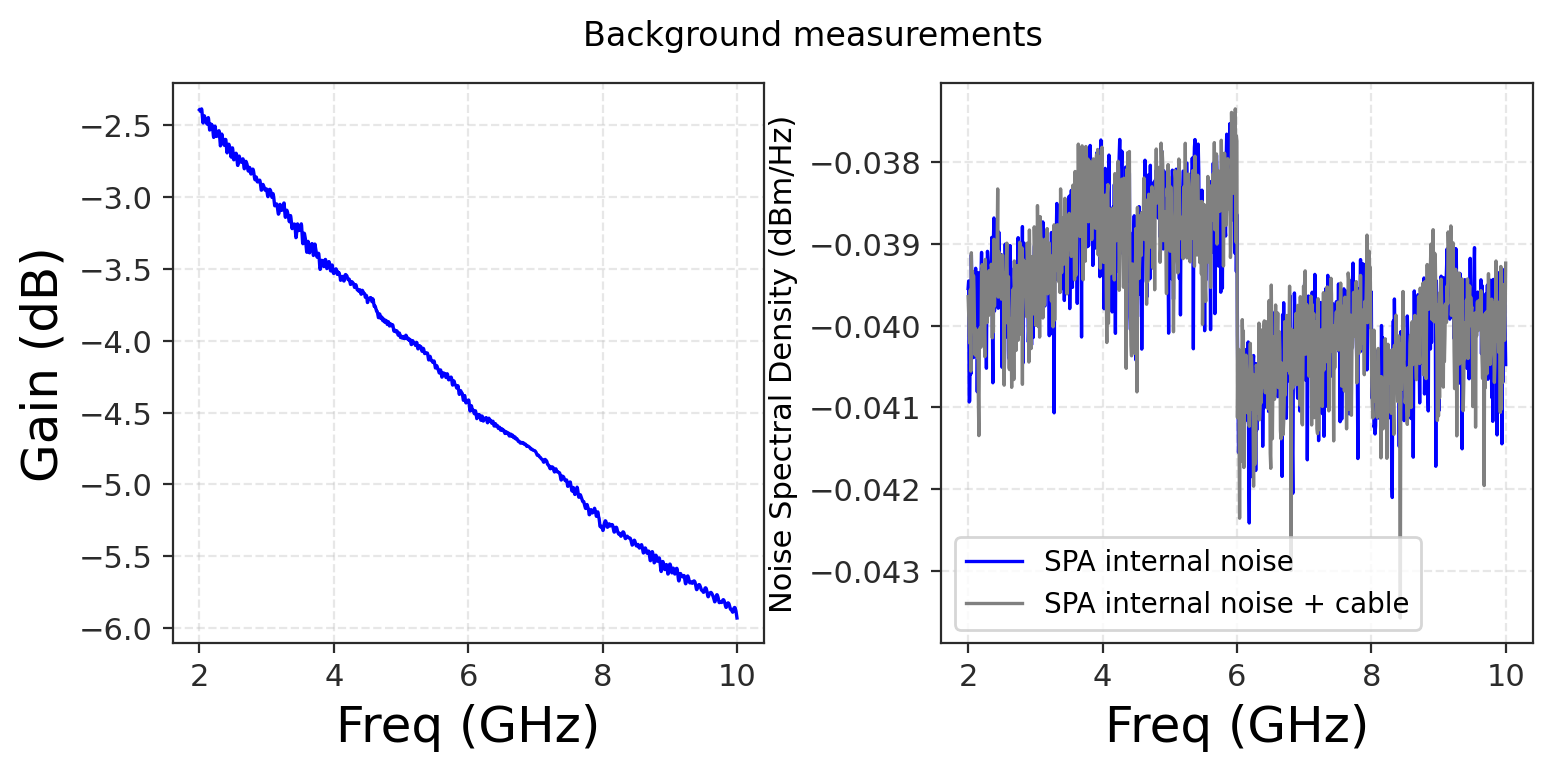

In [131]:
FILENAME = "C:/ExperimentBlue/2021-05_amplifier-calibration/vna-background.txt"
vna_bg = np.loadtxt(FILENAME)
gain_freq = vna_bg[:, 0] / GHz
gain_bg = to_dBm(vna_bg[:, 1])

FILENAME = "C:/ExperimentBlue/2021-05_amplifier-calibration/spa-internal.txt"
spa_internal = np.loadtxt(FILENAME)
noise_freq = spa_internal[:, 0] / 1000
noise_internal = spa_internal[:, 1] / RBW

FILENAME = "C:/ExperimentBlue/2021-05_amplifier-calibration/spa-background.txt"
noise_background = np.loadtxt(FILENAME)[:, 1] / RBW

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(gain_freq, gain_bg, color='b')
ax[0].set_xlabel("Freq (GHz)")
ax[0].set_ylabel("Gain (dB)")

ax[1].plot(noise_freq, noise_internal, color='b', label="SPA internal noise")
ax[1].plot(noise_freq, noise_background, color='gray', label="SPA internal noise + cable")
ax[1].set_xlabel("Freq (GHz)")
ax[1].set_ylabel("Noise Spectral Density (dBm/Hz)", fontsize=11)

ax[1].legend()

fig.suptitle("Background measurements");

## A0X Amplifier A
Since the background noise came mostly from the SPA (see above), any noise difference is simply the noise of the amplifier.
**There is no need to boost the background noise (with is from the SPA) with the amplifiers gain**

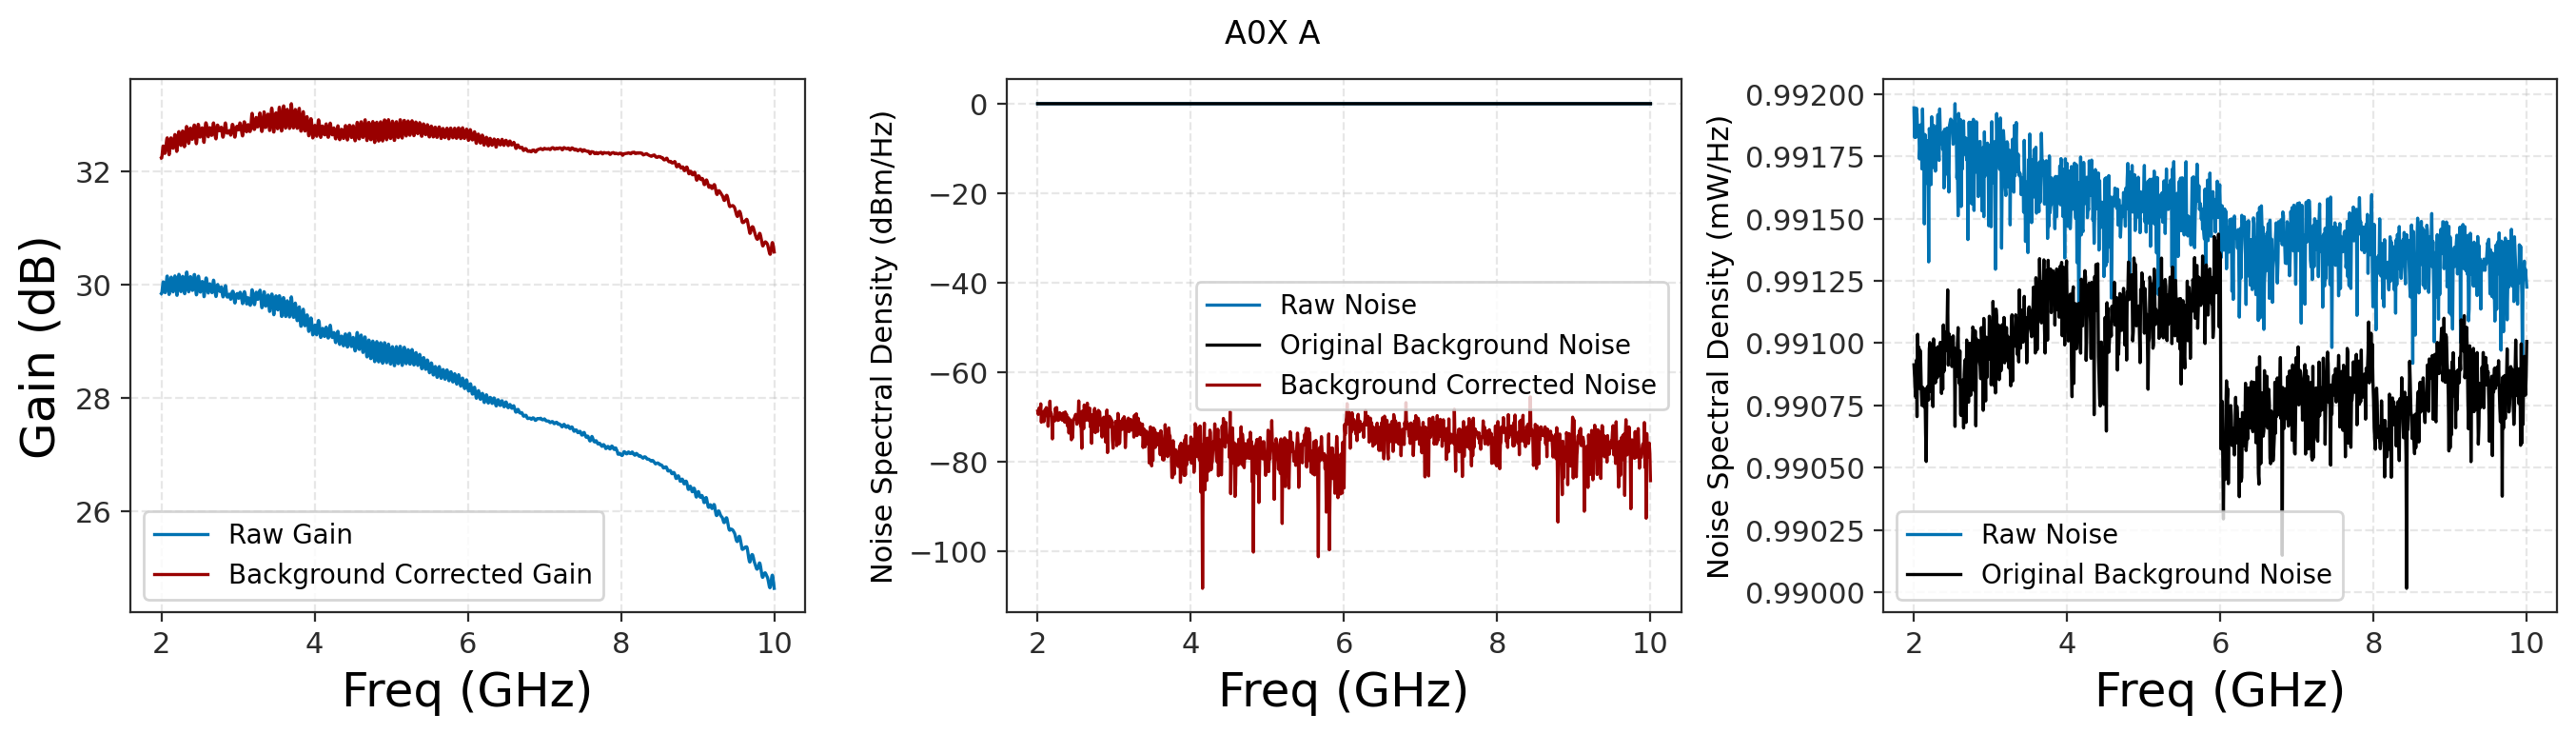

In [135]:
TITLE = "A0X A"
FILENAME = "C:/ExperimentBlue/2021-05_amplifier-calibration/vna-a0x-A.txt"
gain = to_dBm(np.loadtxt(FILENAME)[:, 1])
gain_background_corrected = gain - gain_bg
gain_interpolation = interpolate.interp1d(gain_freq, gain_single_a0x_background_corrected)(noise_freq)
noise_background_with_gain = noise_background + gain_interpolation * 2 # not needed as the background noise is on the SPA, which does not pass through amplifier

FILENAME = "C:/ExperimentBlue/2021-05_amplifier-calibration/spa-a0x-A.txt"
noise = np.loadtxt(FILENAME)[:, 1] / RBW
noise_background_corrected = to_dBm(from_dBm(noise) - from_dBm(noise_background))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(gain_freq, gain, label="Raw Gain", color="C1")
ax[0].plot(gain_freq, gain_background_corrected, label="Background Corrected Gain", color="C4")
ax[0].set_xlabel("Freq (GHz)")
ax[0].set_ylabel("Gain (dB)")

ax[1].plot(noise_freq, noise, label="Raw Noise", color="C1")
ax[1].plot(noise_freq, noise_background, label="Original Background Noise", color="black")
ax[1].plot(noise_freq, noise_background_corrected, label="Background Corrected Noise", color="C4")
ax[1].set_xlabel("Freq (GHz)")
ax[1].set_ylabel("Noise Spectral Density (dBm/Hz)", fontsize=11)

ax[2].plot(noise_freq, from_dBm(noise), label="Raw Noise", color="C1")
ax[2].plot(noise_freq, from_dBm(noise_background), label="Original Background Noise", color="black")
# ax[2].plot(noise_freq, from_dBm(noise_background_with_gain), label="Background Noise with gain", color="C4")
ax[2].set_xlabel("Freq (GHz)")
ax[2].set_ylabel("Noise Spectral Density (mW/Hz)", fontsize=11)

fig.suptitle(TITLE)
ax[0].legend()
ax[1].legend()
ax[2].legend();

## A0X Amplifiers A and B

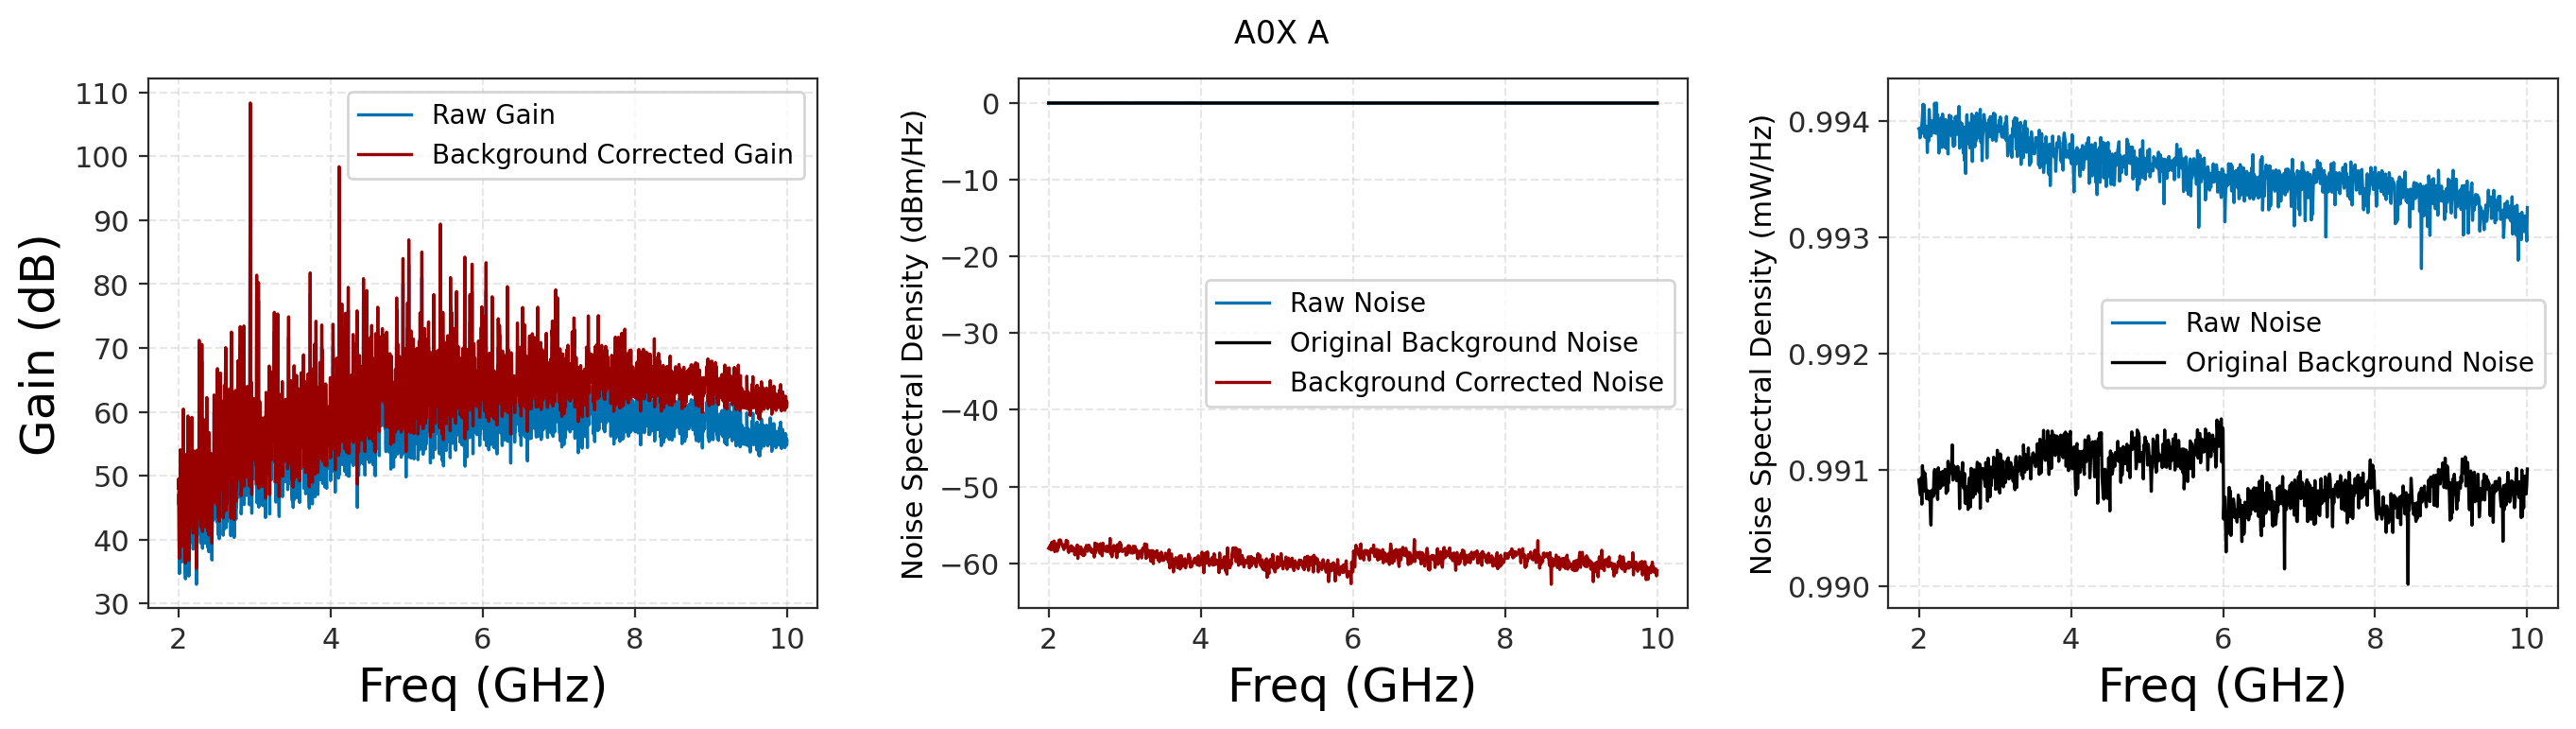

In [137]:
TITLE = "A0X A"
FILENAME = "C:/ExperimentBlue/2021-05_amplifier-calibration/vna-a0x-AB.txt"
gain = to_dBm(np.loadtxt(FILENAME)[:, 1])
gain_background_corrected = gain - gain_bg
gain_interpolation = interpolate.interp1d(gain_freq, gain_single_a0x_background_corrected)(noise_freq)
noise_background_with_gain = noise_background + gain_interpolation * 2 # not needed as the background noise is on the SPA, which does not pass through amplifier

FILENAME = "C:/ExperimentBlue/2021-05_amplifier-calibration/spa-a0x-AB.txt"
noise = np.loadtxt(FILENAME)[:, 1] / RBW
noise_background_corrected = to_dBm(from_dBm(noise) - from_dBm(noise_background))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(gain_freq, gain, label="Raw Gain", color="C1")
ax[0].plot(gain_freq, gain_background_corrected, label="Background Corrected Gain", color="C4")
ax[0].set_xlabel("Freq (GHz)")
ax[0].set_ylabel("Gain (dB)")

ax[1].plot(noise_freq, noise, label="Raw Noise", color="C1")
ax[1].plot(noise_freq, noise_background, label="Original Background Noise", color="black")
ax[1].plot(noise_freq, noise_background_corrected, label="Background Corrected Noise", color="C4")
ax[1].set_xlabel("Freq (GHz)")
ax[1].set_ylabel("Noise Spectral Density (dBm/Hz)", fontsize=11)

ax[2].plot(noise_freq, from_dBm(noise), label="Raw Noise", color="C1")
ax[2].plot(noise_freq, from_dBm(noise_background), label="Original Background Noise", color="black")
# ax[2].plot(noise_freq, from_dBm(noise_background_with_gain), label="Background Noise with gain", color="C4")
ax[2].set_xlabel("Freq (GHz)")
ax[2].set_ylabel("Noise Spectral Density (mW/Hz)", fontsize=11)

fig.suptitle(TITLE)
ax[0].legend()
ax[1].legend()
ax[2].legend();

## A0X Amplifiers A and B and C

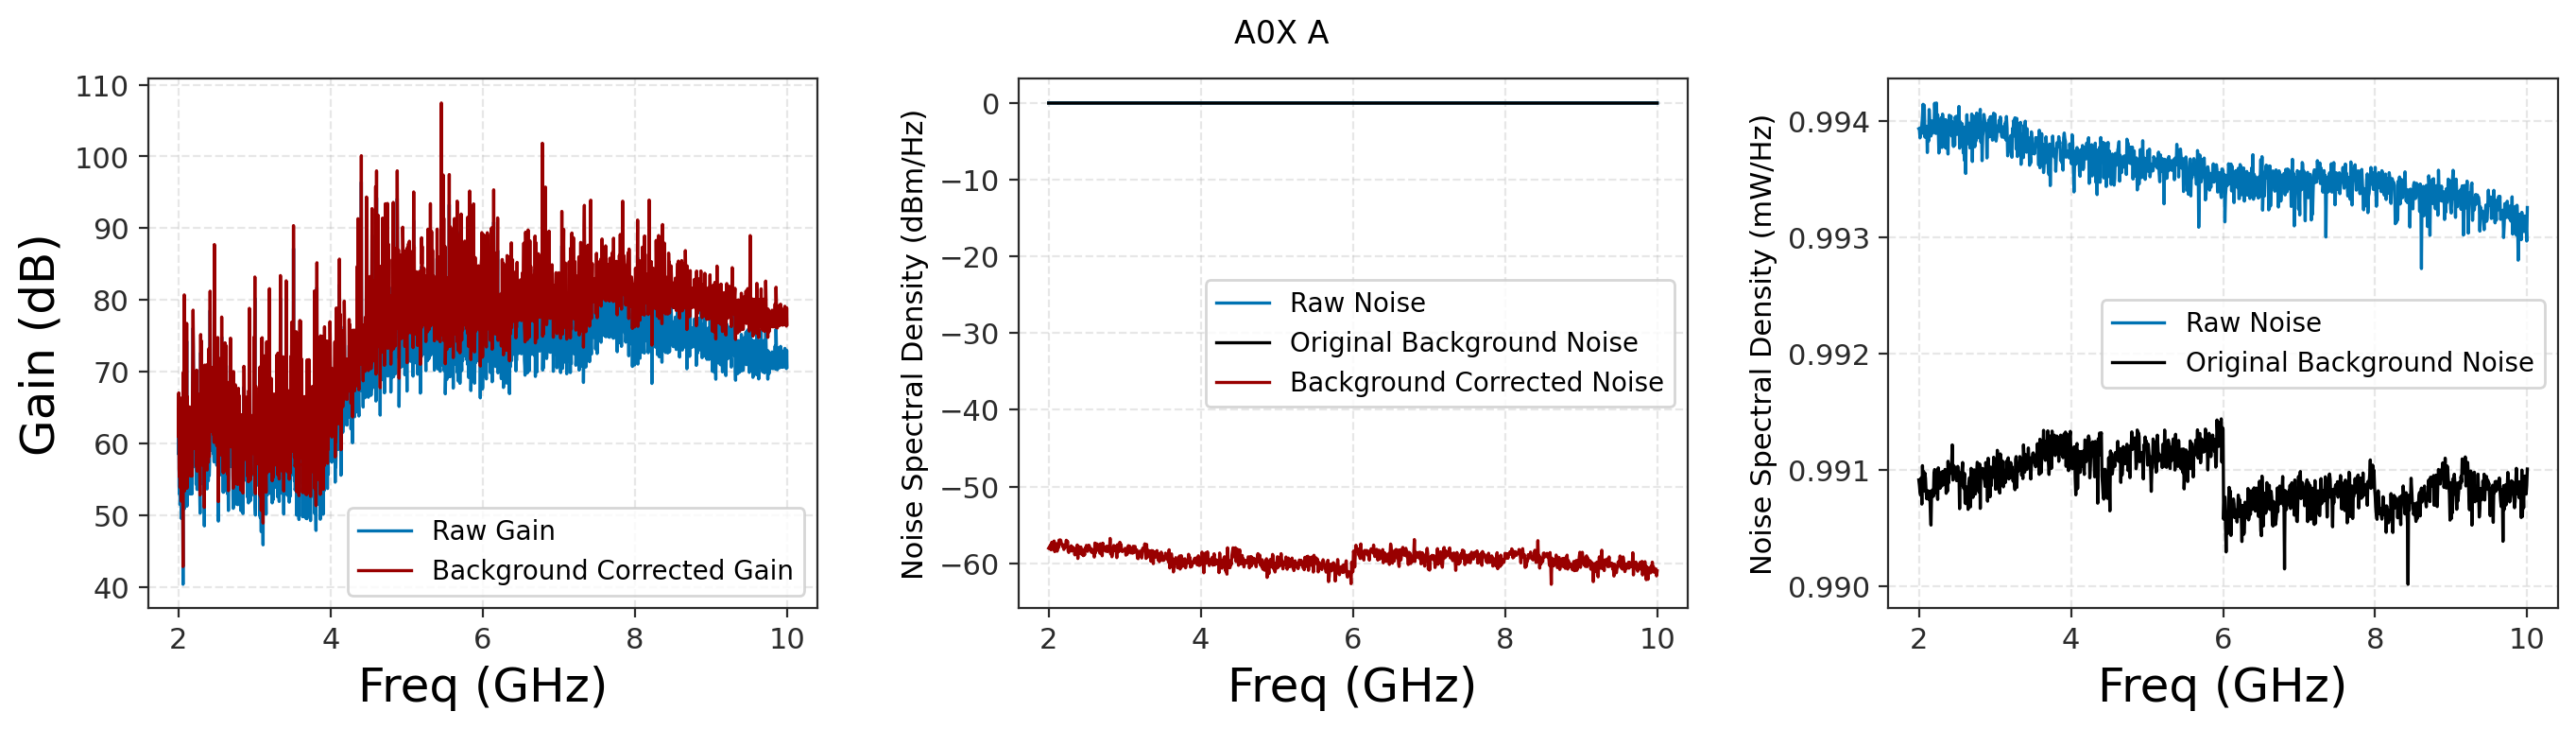

In [138]:
TITLE = "A0X A"
FILENAME = "C:/ExperimentBlue/2021-05_amplifier-calibration/vna-a0x-ABC.txt"
gain = to_dBm(np.loadtxt(FILENAME)[:, 1])
gain_background_corrected = gain - gain_bg
gain_interpolation = interpolate.interp1d(gain_freq, gain_single_a0x_background_corrected)(noise_freq)
noise_background_with_gain = noise_background + gain_interpolation * 2 # not needed as the background noise is on the SPA, which does not pass through amplifier

FILENAME = "C:/ExperimentBlue/2021-05_amplifier-calibration/spa-a0x-ABC.txt"
noise = np.loadtxt(FILENAME)[:, 1] / RBW
noise_background_corrected = to_dBm(from_dBm(noise) - from_dBm(noise_background))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(gain_freq, gain, label="Raw Gain", color="C1")
ax[0].plot(gain_freq, gain_background_corrected, label="Background Corrected Gain", color="C4")
ax[0].set_xlabel("Freq (GHz)")
ax[0].set_ylabel("Gain (dB)")

ax[1].plot(noise_freq, noise, label="Raw Noise", color="C1")
ax[1].plot(noise_freq, noise_background, label="Original Background Noise", color="black")
ax[1].plot(noise_freq, noise_background_corrected, label="Background Corrected Noise", color="C4")
ax[1].set_xlabel("Freq (GHz)")
ax[1].set_ylabel("Noise Spectral Density (dBm/Hz)", fontsize=11)

ax[2].plot(noise_freq, from_dBm(noise), label="Raw Noise", color="C1")
ax[2].plot(noise_freq, from_dBm(noise_background), label="Original Background Noise", color="black")
# ax[2].plot(noise_freq, from_dBm(noise_background_with_gain), label="Background Noise with gain", color="C4")
ax[2].set_xlabel("Freq (GHz)")
ax[2].set_ylabel("Noise Spectral Density (mW/Hz)", fontsize=11)

fig.suptitle(TITLE)
ax[0].legend()
ax[1].legend()
ax[2].legend();